# Lab. 2: Stochastic global optimization

## Introduction

#### <u>The goal of this laboratory is to study the application of stochastic global search algorithms on different benchmark functions.</u>

We will study two methods:
- *DIRECT*
- *Basin-hopping*

Moreover, we will study the effect of their parameters on the outcome of the search.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

You can find a wrapper function for the  two algorithm, together with a wrapper for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)
5.   *trend*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or you can print it with *dir(bf)*.


#### Base code to run every time the runtime is reconnected

In [1]:
%%capture

try:
  import benchmark_functions as bf
  from scipydirect import minimize as spdirect
except:  # colab env
  !pip install benchmark_functions
  !pip install scipydirect
  import benchmark_functions as bf
  from scipydirect import minimize as spdirect

import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import basinhopping as spbasinhopping
import inspect
%matplotlib inline

plt.rcParams["figure.figsize"] = (8,5)

In [2]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        """
        Returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead;

        Returns:
        - List of objects of class "benchmark_functions.functions_info_loader.Optimum"
        - For each object:
          - Access to 'position' parameter to get the axis values
          - Access to 'score' parameter to get the value of the function
        """
        return self.f.minima()

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            xdata = xdata[1:]
            ydata = [x[1] for x in self.history]
            ydata = ydata[1:]

            plt.plot(xdata, ydata, "or-", markersize=5, linewidth=1.5)
            plt.plot(xdata[0], ydata[0], marker='X', markersize=13, color='black')

            plt.plot(xdata[-1], ydata[-1], marker='P', markersize=13,color='white')
            # TODO
            # - bigger markersize for initial and final point + diff color
            # - check f vs func
            # - check num iter vs how many points are being plotted
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        values = values[1:]
        min = func.minima()[0].score

        plt.plot(values, label="Scores",marker='o')

        plt.axhline(min, color="r", label="optimum", linestyle='dashed')
        plt.xlabel('Iterations/Evaluations')  # TODO
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

def grid_search(f: OptFun, step_size=None, number_of_steps=None, minimization=True):
    """
    Optimizes a function by using the grid_search algorithm.

    - f: function to optimize, an instance of OptFun
    - step_size: the step size
    - number_of_steps: the total number of steps
    - minimization: boolean, True if looking for minimum, False if looking for maximum; defauls True

    Returns:
    - best value found
    """

    if (step_size != None):
        range_step_size = step_size
    elif (number_of_steps != None):
        range_step_size = int(np.floor(np.sqrt(number_of_steps)))
    else:
        print("Please provide at least the step_size or the number_of_steps")
        return

    bounds = f.bounds()
    best = float('inf') if minimization else float('sup')

    for x in np.arange(bounds[0][0], bounds[0][1], range_step_size):
        for y in np.arange(bounds[1][0], bounds[1][1], range_step_size):
            current = f([x, y])
            if minimization:
                if current < best:
                    best = current
            else:
                if current > best:
                    best = current

    return best


def direct(f: OptFun, eps: float = 1e-4, maxiter: int = 1000, maxfneval: int = 1000, optima: int = None, error_tollerance: int = None):
    """
    Optimizes a function by using the DIRECT algorithm.

    - f: function to optimize, an instance of OptFun
    - eps: regulates the trade-off between local and global exploration.
            The smaller the eps, the finer the granularity of the search.
    - maxiter: maximum number of iterations
    -
    """
    bounds = f.bounds()
    results =  spdirect(
        func,
        bounds=bounds,
        eps=eps,
        maxT=maxiter,
        maxf=maxfneval,
        fglobal=-1e100,
        fglper=0.001,
        volper=-1.0,
        sigmaper=-1.0
    )
    history = [func.f(v) for v in func.history]
    history = history[1:]
    best_score = min(history)
    best_position = func.history[history.index(best_score)]
    return results, best_position, best_score


def basinhopping(
    f: OptFun,
    x0: np.ndarray,
    T: float = 1.0,
    stepsize: float = 0.5,
    stepsize_interval: int = 50,
    maxiter: int = 1000):
    """
    Optimizes a function by using the Basin-hopping algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - T: temperature parameter
    - stepsize: maximum step size for random displacement
    - stepsize_interval: interval for the update of the step size
    - maxiter: maximum number of iterations
    """
    return spbasinhopping(
        f,
        x0,
        niter=maxiter,
        T=T,
        stepsize=stepsize,
        minimizer_kwargs=None,
        take_step=None,
        accept_test=None,
        callback=None,
        interval=stepsize_interval,
        disp=False,
        niter_success=None,
        seed=None,
    )

In [3]:
def printClassInitArgs(class_obj):
    print(f'{class_obj.name()}')
    signature = inspect.signature(class_obj.__init__).parameters
    print("-------------------------------")
    for name, parameter in signature.items():
        if name != 'opposite':
            print("Name: ", name, "\nDefault value:", parameter.default)
            #print("Annotation:", parameter.annotation, "\nKind:", parameter.kind)
            print("-------------------------------")

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- How do the approaches seen in today's lab compare to the one seen in the previous lab?

In [4]:
# BE AWARE: check the arguments each benchmark function takes
# if you're not sure, you can check the arguments by using the printClassInitArgs function
print(dir(bf))
printClassInitArgs(bf.Hypersphere())

['ABC', 'Ackley', 'BenchmarkFunction', 'DeJong3', 'DeJong5', 'Easom', 'EggHolder', 'GoldsteinAndPrice', 'Griewank', 'Himmelblau', 'Hyperellipsoid', 'Hypersphere', 'Keane', 'MartinGaddy', 'McCormick', 'Michalewicz', 'PichenyGoldsteinAndPrice', 'PitsAndHoles', 'Rana', 'Rastrigin', 'Rosenbrock', 'Schaffer2', 'Schwefel', 'StyblinskiTang', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'abstractmethod', 'benchmark_functions', 'fil', 'functions_info_loader', 'logging', 'math', 'multivariate_normal', 'np']
Hypersphere
-------------------------------
Name:  n_dimensions 
Default value: 2
-------------------------------


## Exercise 1/2: DIRECT
In this first exercise we will use [DIRECT](https://scipydirect.readthedocs.io/en/latest/reference.html) as a search algorithm

### Questions
- How does the eps parameter influence the search process?
- How does the number of maximum iterations influence the search process? (To note: the maximum iterations and maximum number of evalutions are the soly metrics used to reach a stopping condition)

In [5]:
'''
## Exercise 1/2: DIRECT
In this first exercise we will use [DIRECT](https://scipydirect.readthedocs.io/en/latest/reference.html) as a search algorithm

### Questions
- How does the eps parameter influence the search process?

A lower value of epsilon allows me to find a more accurate estimate of the function's minimum. 
The criterion for selecting the new rectangle is based on epsilon through 
the inequality: f(cj)-Kdj ≤ fmin - ε | fmin |.
This implies that the difference between the function value at the central point of the 
new rectangle and the value of K multiplied by the rectangle's dimension must be less than the 
difference between the current minimum value and epsilon multiplied by the absolute value of the minimum.
If this inequality is satisfied, then the new rectangle will be chosen for exploration.

- How does the number of maximum iterations influence the search process? (To note: the maximum iterations and 
maximum number of evalutions are the soly metrics used to reach a stopping condition)

Increasing the number of iterations leads to selecting more rectangles and dividing the
search space into increasingly smaller regions. As the number of iterations increases, 
the algorithm tends to converge towards a local search. Simple functions may converge even with
a low number of iterations, whereas complex functions require a higher number of iterations. 
If the minimum lies in the corners, the convergence becomes more challenging.

'''

"\n## Exercise 1/2: DIRECT\nIn this first exercise we will use [DIRECT](https://scipydirect.readthedocs.io/en/latest/reference.html) as a search algorithm\n\n### Questions\n- How does the eps parameter influence the search process?\n\nA lower value of epsilon allows me to find a more accurate estimate of the function's minimum. \nThe criterion for selecting the new rectangle is based on epsilon through \nthe inequality: f(cj)-Kdj ≤ fmin - ε | fmin |.\nThis implies that the difference between the function value at the central point of the \nnew rectangle and the value of K multiplied by the rectangle's dimension must be less than the \ndifference between the current minimum value and epsilon multiplied by the absolute value of the minimum.\nIf this inequality is satisfied, then the new rectangle will be chosen for exploration.\n\n- How does the number of maximum iterations influence the search process? (To note: the maximum iterations and \nmaximum number of evalutions are the soly metr

In [6]:
funzioni = [bf.Hypersphere(), bf.Rastrigin(), bf.DeJong5(), bf.Keane()]
#funzioni = [bf.Keane()]

In [7]:
for funzione in funzioni:
    print("FUNZIONE ", funzione)
    func = OptFun(funzione)  # TODO: try differenct benchmark function
    eps_list = [1, 0.1, 0.001, 0.0001]  # TODO: try different values
    eps_list = [0.0001]
    max_iter = 20  # TODO: try different values
    max_eval = 40  # TODO try different values

    for eps in eps_list:
        func = OptFun(funzione)
        print('\neps = ', eps)
        res, best_location, best_value = direct(func, eps, max_iter, max_eval)
        print('Result:', res)
        print("Best value:", best_value)
        print("Best location:", best_location)

        func.heatmap()
        func.plot()

FUNZIONE  <benchmark_functions.benchmark_functions.Hypersphere object at 0x000002244EE06290>

eps =  0.0001


TypeError: 'NoneType' object is not callable

## Exercise 2/2: BASIN-HOPPING
In this exercise we will use [Basin-hopping](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html) as a search algorithm

### Questions
- What is the influence of the following parameters on the search process?
  - **T:** The “temperature” parameter for the acceptance or rejection criterion. Higher “temperatures” mean that larger jumps in function value will be accepted. For best results T should be comparable to the separation (in function value) between local minima;
  - **stepsize:** Maximum step size for use in the random displacement;
  - **stepsize_interval:** interval for how often to update the stepsize;
  - **niter:** The number of basin-hopping iterations.
- How does the number of maximum iterations influence the search process?

By using a higher number of iterations we can jump more and conseguently explore more space, incresing the probability of finding a global optima solution. 

- How does the starting point influence the search process?

If the starting point is closer to the minima then we are more in an advantege of finding the best solution. But if the temperature is too high we could choose to jump even if we are already in the neighbourhood of the global optima. 

Best value: -507.87385942100235
Best location: [-408.7198071  -156.10117083]


<Figure size 800x500 with 0 Axes>

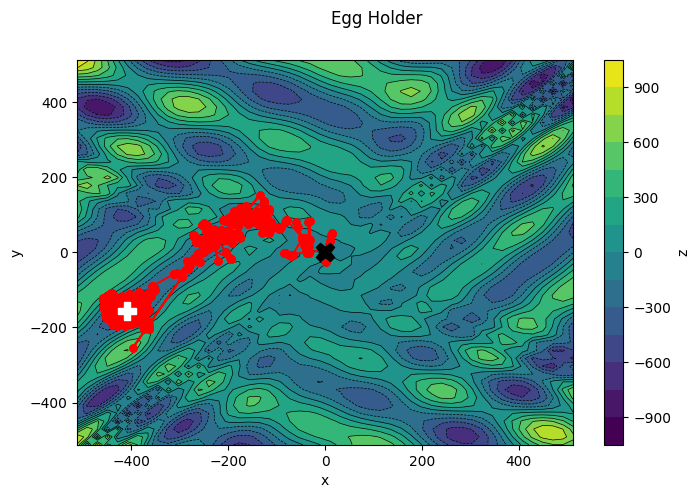

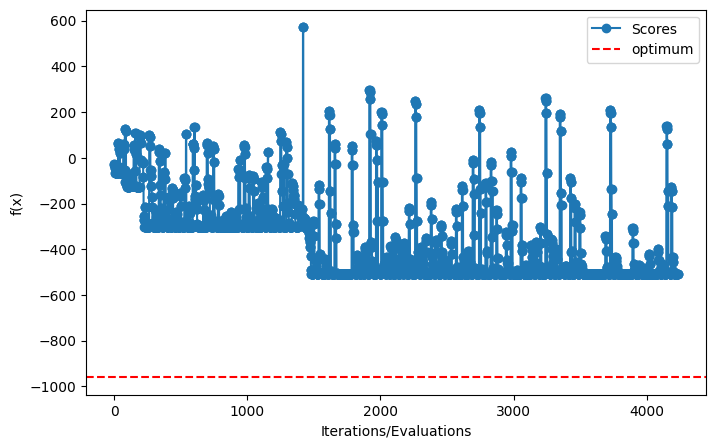

In [ ]:
func = OptFun(bf.EggHolder()) # TODO: try differenct benchmark functions
x_0 = [-300, 200] # set it appropriate for the funch used 
x_0 = [0,0]
T = 20 # TODO: try different values 
stepsize = 50 # TODO: try different values 
stepsize_interval = 0.1 # TODO: try different values 
n_iter = 100 # TODO: try different values

res = basinhopping(func, x_0, T, stepsize, stepsize_interval, n_iter) 
best_value, best_location = res['fun'], res['x'] 
print("Best value:", best_value) 
print("Best location:", best_location)

func.heatmap() 
func.plot()

Best value: 0.0
Best location: [0. 0.]


<Figure size 800x500 with 0 Axes>

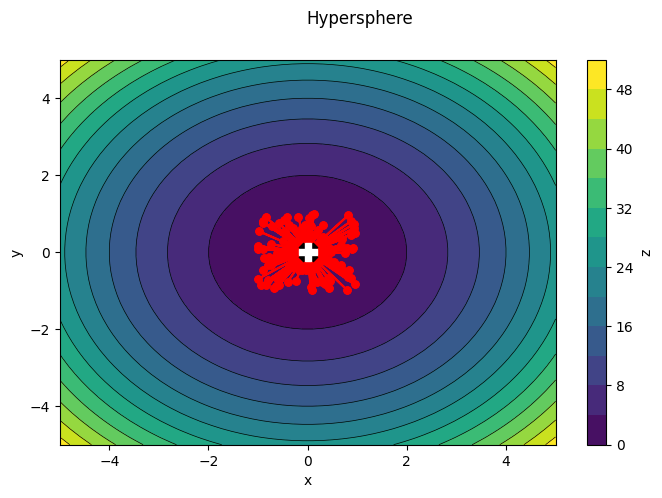

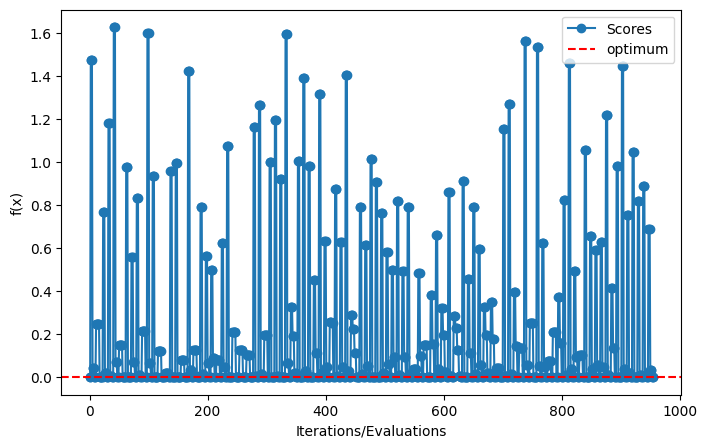

In [ ]:
func = OptFun(bf.Hypersphere()) # TODO: try differenct benchmark functions
x_0 = [-300, 200] # set it appropriate for the funch used 
x_0 = [0,0]
T = 10000 # TODO: try different values 
stepsize = 1 # TODO: try different values 
stepsize_interval = 0.000001 # TODO: try different values 
n_iter = 1 # TODO: try different values

res = basinhopping(func, x_0, T, stepsize, stepsize_interval, n_iter) 
best_value, best_location = res['fun'], res['x'] 
print("Best value:", best_value) 
print("Best location:", best_location)

func.heatmap() 
func.plot()

## Final questions
- How do the approaches seen in today's lab compare to the one seen in the previous lab?

In [ ]:
DIRECT è ideale per una ricerca sistematica e deterministica, particolarmente in scenari di ottimizzazione globale con funzioni complesse. Basin Hopping è eccellente per superare i minimi locali in funzioni con molte valli, utilizzando una strategia stocastica per saltare tra differenti regioni dell'iperspazio. Entrambi sono generalmente più sofisticati e adatti per problemi complessi rispetto a metodi più semplici come Grid Search e Random Search, e offrono vantaggi rispetto a metodi locali come Powell e Nelder-Mead, specialmente in contesti di ottimizzazione globale. Powell e Nelder-Mead sono più orientati verso ottimizzazioni locali. Entrambi non richiedono gradienti, rendendoli utili per funzioni non differenziabili ma tendono lo stesso ad intrappolarsi in minimi locali. Basin hopping con un buon fine-tune dello step size per funzioni complesse (es. vedi Rastrigin nel notebook) riesce a sfuggire dal minimo locale e trovare un'ottima soluzione. Cosa che gli algoritmi che abbiamo visto nel lab precedente non hanno capacità di fare